In this notebook, we'll be building a generative adversarial network (GAN) and an autoencoder trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

Let's first import packages and load data

In [ ]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training and testing datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 40253621.31it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105152512.00it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 16822524.92it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12717308.92it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Visualize the data

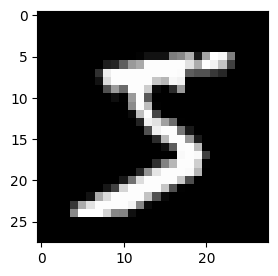

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Generative Adversarial Network



GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/)
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake.
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data.
* The discriminator is a classifier that is trained to figure out which data is real and which is fake.

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/gan_pipeline.png?raw=true' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!

---
## Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

### Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/gan_network.png?raw=true' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/leaky_relu.png?raw=true' width=40% />

If you stare this figure closely enough, you'll see that there is a small negative ouput for negative input values. The negative slope is 0.01 by default.

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_.
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** binary cross entropy loss in one function.

So, our final output layer should not have any activation function applied to it.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()

        # TODO: define hidden linear layers
        # First hidden layer with hidden_dim*4 hidden units
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        # Second hidden layer with hidden_dim*2 hidden units
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        # Third hidden layer with hidden_dim hidden units
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):

        # TODO: flatten image
        x = x.view(-1, 28*28)
        # all hidden layers with Leaky Relu activations and negative slope = 0.2
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out


### Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $\tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/tanh_fn.png?raw=true' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1.
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator.

We'll do this in the training loop, later on.

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        # TODO: define hidden linear layers
        # First hidden layer with hidden_dim hidden units
        self.fc1 = nn.Linear(input_size, hidden_dim)
        # Second hidden layer with hidden_dim*2 hidden units
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        # Third hidden layer with hidden_dim*4 hidden units
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # TODO: all hidden layers with Leaky Relu activations and negative slope = 0.2
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied so that we get output in [-1, 1]
        out = F.tanh(self.fc4(x))

        return out

## Model hyperparameters

In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [ ]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/gan_pipeline.png?raw=true' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`.

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
        labels=labels.to(device)
    else:
        labels = torch.ones(batch_size) # real labels = 1
        labels = labels.to(device)

    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # TODO: calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels =labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # TODO: calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [ ]:
import torch.optim as optim

# Optimizers
lr = 0.002

# TODO: Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples. Note that we use [pickle package](https://www.geeksforgeeks.org/understanding-python-pickling-example/) to  convert a Python object (list, dictionary, etc.) into a character stream and write it to a file.

In [ ]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)

# train the network
D.train()
G.train()
for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):

        batch_size = real_images.size(0)

        ## Important rescaling step ##
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        # 1. Train with real images

        # TODO: Compute the discriminator losses on real images
        # smooth the real labels
        real_images=real_images.to(device)
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # 2. Train with fake images

        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            z = z.to(device)
            fake_images = G(z)

        # TODO: Compute the discriminator losses on fake images
        fake_images=fake_images.to(device)
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================

        # 1. Train with fake images and flipped labels

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z)

        # TODO: Compute the generator losses on fake images
        # Hint: use real loss to flip labels!
        fake_images=fake_images.to(device)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels

        # perform backprop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))


    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3646 | g_loss: 0.7824
Epoch [    1/  100] | d_loss: 1.2472 | g_loss: 1.3714
Epoch [    1/  100] | d_loss: 1.1564 | g_loss: 1.6718
Epoch [    2/  100] | d_loss: 1.2585 | g_loss: 0.9382
Epoch [    2/  100] | d_loss: 1.1274 | g_loss: 1.0109
Epoch [    2/  100] | d_loss: 1.2079 | g_loss: 0.9647
Epoch [    3/  100] | d_loss: 1.3722 | g_loss: 0.9157
Epoch [    3/  100] | d_loss: 1.1811 | g_loss: 1.0435
Epoch [    3/  100] | d_loss: 0.8884 | g_loss: 1.7058
Epoch [    4/  100] | d_loss: 0.9806 | g_loss: 1.3012
Epoch [    4/  100] | d_loss: 1.0746 | g_loss: 1.0379
Epoch [    4/  100] | d_loss: 1.1609 | g_loss: 1.0689
Epoch [    5/  100] | d_loss: 1.1897 | g_loss: 1.1628
Epoch [    5/  100] | d_loss: 1.1360 | g_loss: 1.4328
Epoch [    5/  100] | d_loss: 1.4359 | g_loss: 0.9940
Epoch [    6/  100] | d_loss: 1.1643 | g_loss: 1.1301
Epoch [    6/  100] | d_loss: 1.2145 | g_loss: 1.2933
Epoch [    6/  100] | d_loss: 1.0724 | g_loss: 1.5685
Epoch [    7/  100] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

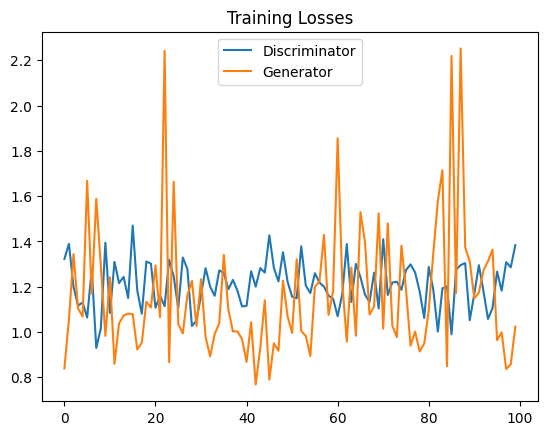

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.cpu().detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

We have 16 samples of images generated across 100 epochs.

In [ ]:
len(samples)

100

In [ ]:
samples[0].shape

torch.Size([16, 784])

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

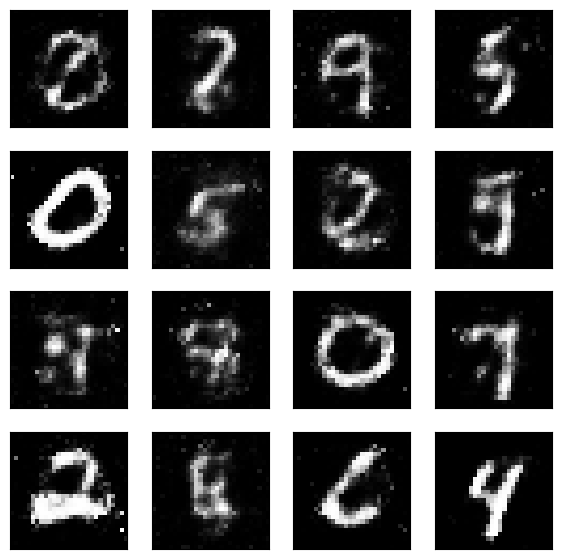

In [ ]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

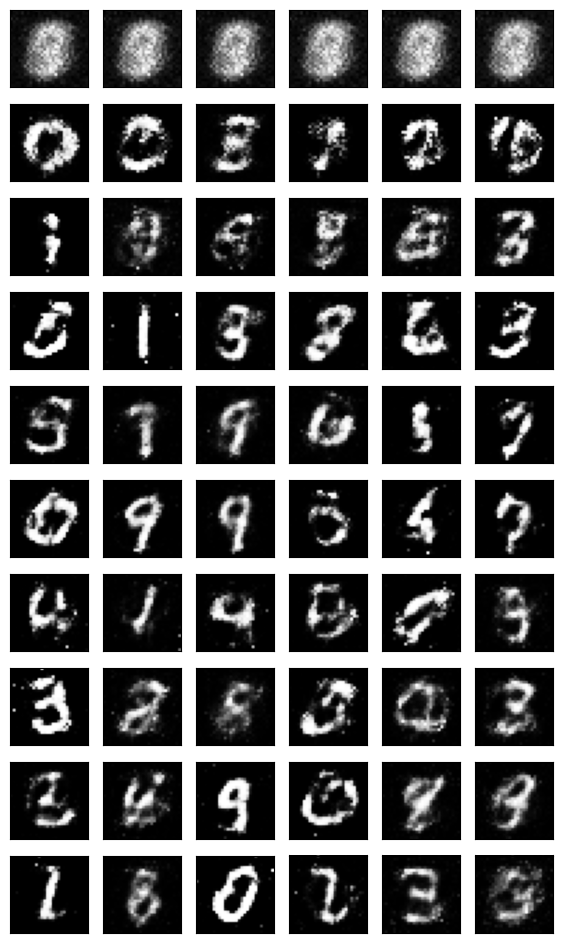

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6  # take 6 different images
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes): # get sample from every 10-th element in samples
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):  # get image from every (16/6)-th element in sample
    #for img, ax in zip(sample[0:cols], ax_row):  # get image from every (16/6)-th element in sample
        img = img.cpu().detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

The rows represent every 10 epochs and the columns represent different generated images. It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

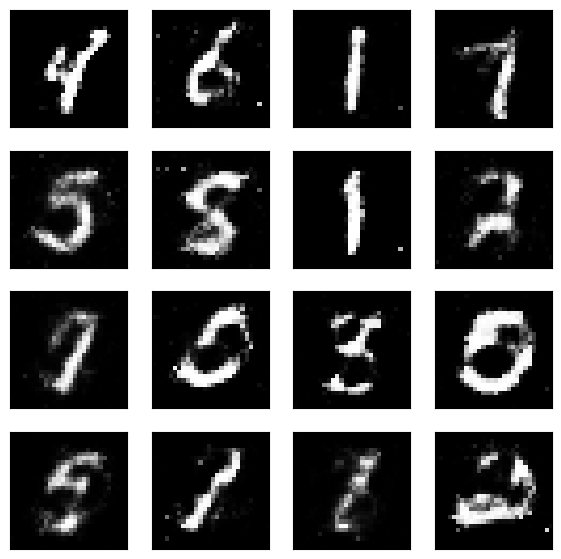

In [ ]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
rand_z = rand_z.to(device)
G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

---
# Auto-Encoder

Now, let's move to build and train Autoencoder.


We first define some helper functions for plotting.

In [ ]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
model

AutoEncoder(
  (encoder): Linear(in_features=784, out_features=64, bias=True)
  (decoder): Linear(in_features=64, out_features=784, bias=True)
)

Why did we take 784 as input dimension? This is because each image has size 28*28.

In [ ]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            output = model(data)
            loss = loss_fn(output, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.047682
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.033304
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.030053
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.025275
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.022430
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.020165
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.021108
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.017880
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.018397
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.017014
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.016098
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.016593
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.017193
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.015976
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.015293
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.015364
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.016751
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.014907
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.015961
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.014918
Train Epoch:

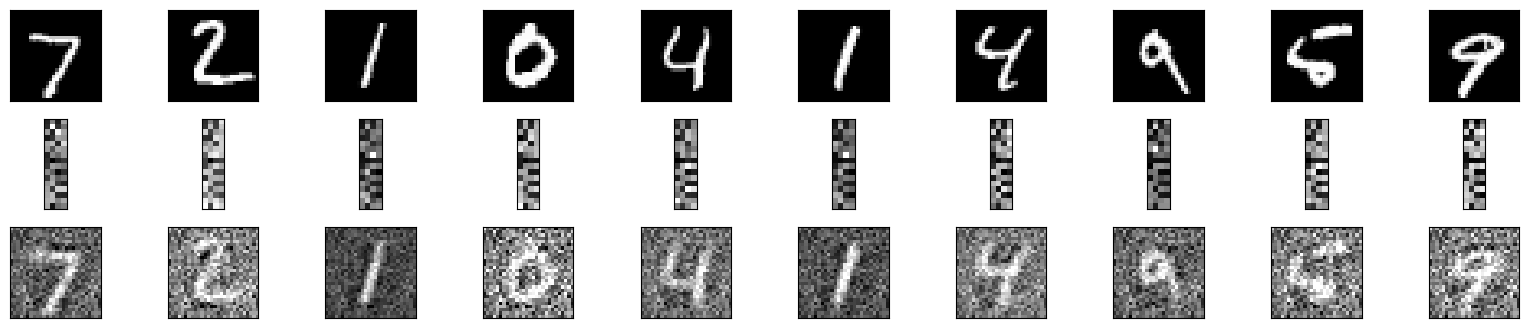

In [ ]:
plot_reconstructions(model)

Note that the above encoder compresses the original 784-dim data to 64-dim latent vector, a compression factor of 12.25.

This autoencoder has been trained to squish down an image to a smaller representation and then re-create the image back from this compressed version again. In this particular case the compression factor is 12.25, we start with a 28x28(htxwd) image and it get compressed to a latent vector of dimension 64.

## Autoencoder with MLP

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and the third one of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            #TODOs: define the MLP for encoder
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
        )

        #TODOs: define the MLP for decoder
        self.decoder = nn.Sequential(
          nn.Linear(encoding_dim, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [ ]:
model

DeepAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)

In [ ]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.113045
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.054468
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.037556
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.036062
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.032145
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.029406
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.026874
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.027498
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.024869
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.024844
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.023355
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.022807
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.022658
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.023517
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.021793
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.021199
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.020065
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.021683
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.019598
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.019753
Train Epoch:

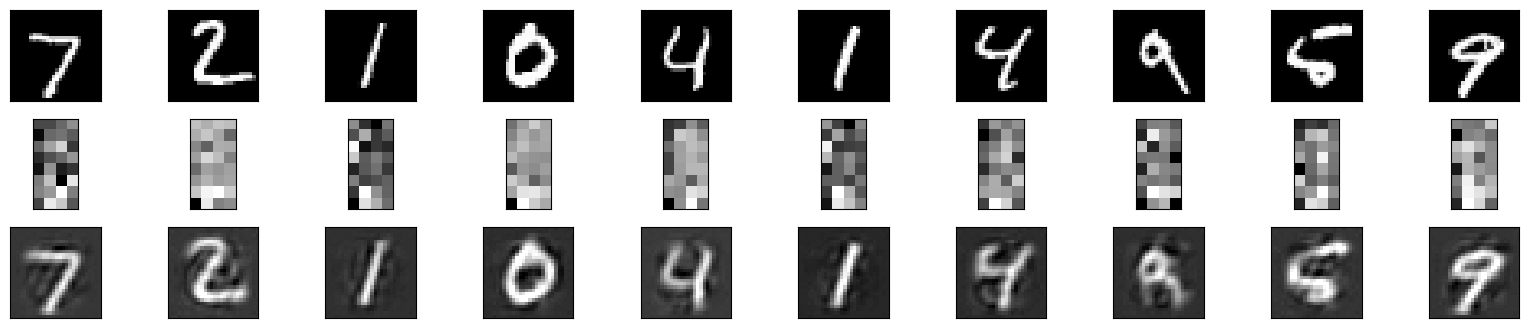

In [ ]:
plot_reconstructions(model)

We can see that with deep autoencoder and decoder, we achieve better reconstruction, even with 32-dimensional latent vector. However, the reconstructed picture is a bit blurred.

To get a clear reconstruction, let's replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`, which is often used for classification problem. Here  using the `BCEWithLogitsLoss` encourages the model to take values close to 0 and 1, thus sharpening the reconstructed images.

In [ ]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn =torch.nn.BCEWithLogitsLoss()
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.691626
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.268551
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.233890
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.258543
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.209974
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.184302
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.168931
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.165912
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.159702
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.154012
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.148058
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.149802
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.138773
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.151967
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.146052
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.144179
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.133050
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.137756
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.130968
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.130947
Train Epoch:

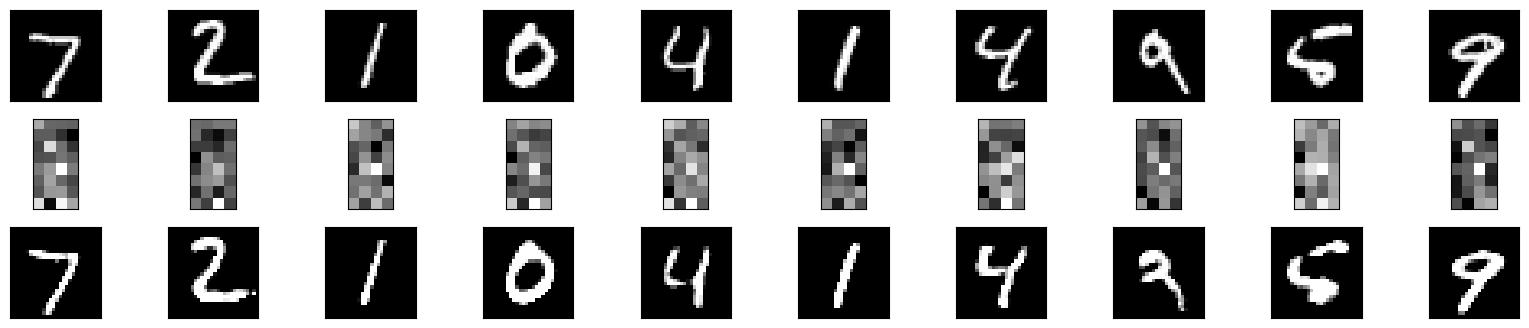

In [ ]:
plot_reconstructions(model)

## Interpolation on Latent Space

You may wonder why do we even use an autoencoder? It seems that we just map the original image to a low-dimensional latent vector and map it back! It turns out we can do a lot of interesting operations on the latent space (for example, diffusion). If we directly operate on the original image in pixel space, this means processing a LOT of data, and  make high-resolution generation very computationally expensive.  Instead, we operate on the latent space, using the compressed representations from our AE rather than raw images. These representations are information rich, and can be small enough to handle manageably on consumer hardware. Once we've generated a new 'image' as a latent representation, the autoencoder can take those final latent outputs and turn them into actual pixels.

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

In [ ]:
data, labels = next(iter(test_loader))
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])

In [ ]:
encoded_0 = model.encoder(data[1].view(-1,784).to(device))
encoded_1 = model.encoder(data[9].view(-1,784).to(device))

In [ ]:
alpha = torch.linspace(0,1,steps=10)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1

In [ ]:
decoded_imgs = model.decoder(interp)

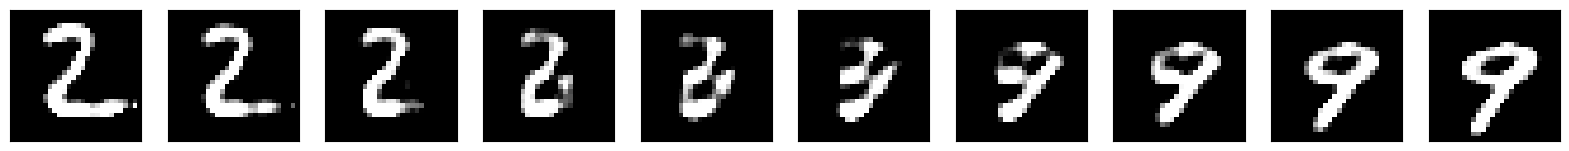

In [ ]:
decoded_imgs = to_img(decoded_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)

    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
n = 100
alpha = torch.linspace(0,1,steps=n)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1
decoded_imgs = model.decoder(interp)
decoded_imgs = to_img(decoded_imgs)

In [ ]:
import matplotlib.animation as animation

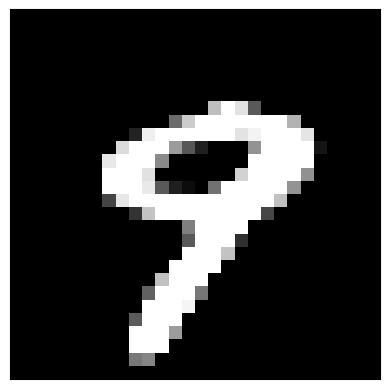

In [ ]:
fig, ax = plt.subplots()
ims = []
for i in range(len(decoded_imgs)):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(decoded_imgs[i], animated=True)
    if i == 0:
        ax.imshow(decoded_imgs[0])  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
writergif = animation.PillowWriter(fps=30)
ani.save("AE_interpolate.gif",writer=writergif)
plt.show()

---
## Denoising Autoencoder


Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

<img src='https://github.com/RankJay/Deep-Learning-with-Pytorch-from-Facebook-Udacity/blob/master/Autoencoder/denoising-autoencoder/notebook_ims/autoencoder_denoise.png?raw=1' width=70%/>


Autoencoders can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. Similar ideas are also used in diffusion models to denoise noisy images iteratively.

>**We'll use noisy images as input and the original, clean images as targets.**

Below is an example of some of the noisy images I generated and the associated, denoised images.

<img src='https://github.com/RankJay/Deep-Learning-with-Pytorch-from-Facebook-Udacity/blob/master/Autoencoder/denoising-autoencoder/notebook_ims/denoising.png?raw=1' />


Since this is a harder problem for the network, we'll want to use _deeper_ convolutional layers here; layers with more feature maps. You might also consider adding additional layers. I suggest starting with a depth of 32 for the convolutional layers in the encoder, and the same depths going backward through the decoder.


Note that for the decoder layers, we will like to increase the spatial dimensions, so we will use [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). The idea is very similar to `nn.Conv2d`, but it increases the spatial dimension instead of decreasing. We will not cover this concept in class, but you can watch for this [video](https://www.youtube.com/watch?v=4BliqgvI8mk) to understand this if you're interested.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()

        ## encoder layers ##
        # TODO: add convolution and pooling layers
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))

        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
model=model.to(device)

---
### Training

We are only concerned with the training images, which we can get from the `train_loader`.

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data

        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        # send the data to the device
        images = images.to(device)
        noisy_imgs = noisy_imgs.to(device)

        #1. forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        #2. calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        #3. clear the gradients of all optimized variables
        optimizer.zero_grad()
        #4. backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #5. perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 4.058947
Epoch: 2 	Training Loss: 2.392330
Epoch: 3 	Training Loss: 2.057497
Epoch: 4 	Training Loss: 1.909281
Epoch: 5 	Training Loss: 1.823996
Epoch: 6 	Training Loss: 1.768829
Epoch: 7 	Training Loss: 1.722562
Epoch: 8 	Training Loss: 1.686257
Epoch: 9 	Training Loss: 1.656085
Epoch: 10 	Training Loss: 1.628601
Epoch: 11 	Training Loss: 1.608350
Epoch: 12 	Training Loss: 1.587558
Epoch: 13 	Training Loss: 1.570016
Epoch: 14 	Training Loss: 1.553050
Epoch: 15 	Training Loss: 1.538696
Epoch: 16 	Training Loss: 1.527131
Epoch: 17 	Training Loss: 1.510995
Epoch: 18 	Training Loss: 1.498064
Epoch: 19 	Training Loss: 1.488032
Epoch: 20 	Training Loss: 1.475994


### Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

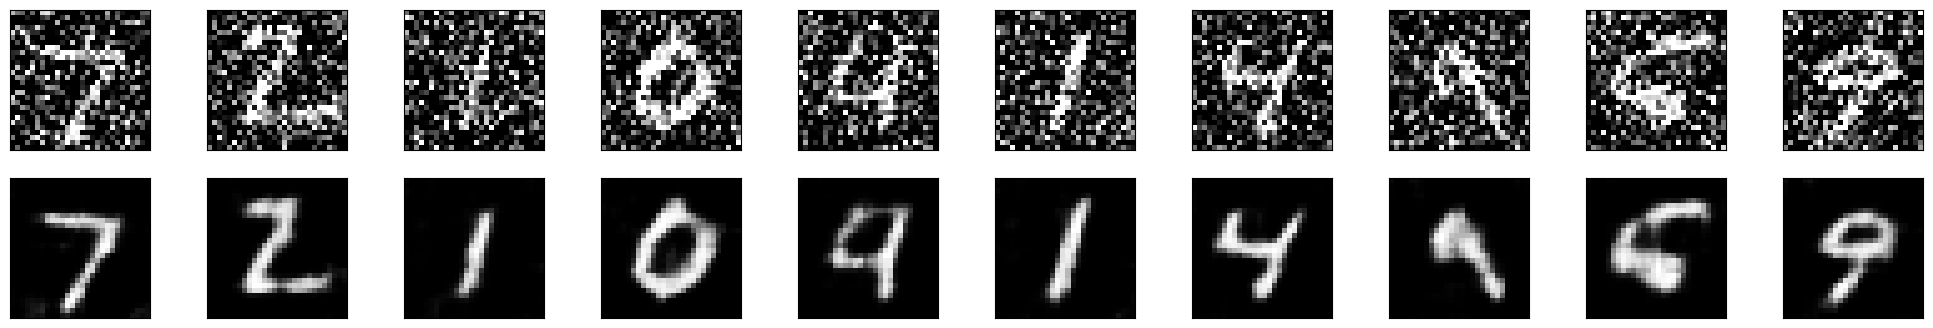

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

noisy_imgs=noisy_imgs.to(device)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# output is resized into a batch of iages
output = output.view(-1, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)